In [1]:
import math
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:


class Value:
  
  def __init__(self, data, _children=(), _op='', label=''):
    self.data = data
    self.grad = 0.0
    self._backward = lambda: None
    self._prev = set(_children)
    self._op = _op
    self.label = label

  def __repr__(self):
    return f"Value(data={self.data})"
  
  def __add__(self, other):
    other = other if isinstance(other, Value) else Value(other)
    out = Value(self.data + other.data, (self, other), '+')
    
    def _backward():
      self.grad += 1.0 * out.grad
      other.grad += 1.0 * out.grad
    out._backward = _backward
    
    return out

  def __mul__(self, other):
    other = other if isinstance(other, Value) else Value(other)
    out = Value(self.data * other.data, (self, other), '*')
    
    def _backward():
      self.grad += other.data * out.grad
      other.grad += self.data * out.grad
    out._backward = _backward
      
    return out
  
  def __pow__(self, other):
    assert isinstance(other, (int, float)), "only supporting int/float powers for now"
    out = Value(self.data**other, (self,), f'**{other}')

    def _backward():
        self.grad += other * (self.data ** (other - 1)) * out.grad
    out._backward = _backward

    return out
  
  def __rmul__(self, other): # other * self
    return self * other

  def __truediv__(self, other): # self / other
    return self * other**-1

  def __neg__(self): # -self
    return self * -1

  def __sub__(self, other): # self - other
    return self + (-other)

  def __radd__(self, other): # other + self
    return self + other

  def tanh(self):
    x = self.data
    t = (math.exp(2*x) - 1)/(math.exp(2*x) + 1)
    out = Value(t, (self, ), 'tanh')
    
    def _backward():
      self.grad += (1 - t**2) * out.grad
    out._backward = _backward
    
    return out
  
  def exp(self):
    x = self.data
    out = Value(math.exp(x), (self, ), 'exp')
    
    def _backward():
      self.grad += out.data * out.grad 
    out._backward = _backward
    
    return out
  
  
  def backward(self):
    
    topo = []
    visited = set()
    def build_topo(v):
      if v not in visited:
        visited.add(v)
        for child in v._prev:
          build_topo(child)
        topo.append(v)
    build_topo(self)
    
    self.grad = 1.0
    for node in reversed(topo):
      node._backward()



In [ ]:


from graphviz import Digraph

def trace(root):
  # builds a set of all nodes and edges in a graph
  nodes, edges = set(), set()
  def build(v):
    if v not in nodes:
      nodes.add(v)13th Gen Intel® Core™ i7-13700K × 24
      for child in v._prev:
        edges.add((child, v))
        build(child)
  build(root)
  return nodes, edges

def draw_dot(root):
  dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'}) # LR = left to right
  
  nodes, edges = trace(root)
  for n in nodes:
    uid = str(id(n))
    # for any value in the graph, create a rectangular ('record') node for it
    dot.node(name = uid, label = "{ %s | data %.4f | grad %.4f }" % (n.label, n.data, n.grad), shape='record')
    if n._op:
      # if this value is a result of some operation, create an op node for it
      dot.node(name = uid + n._op, label = n._op)
      # and connect this node to it
      dot.edge(uid + n._op, uid)

  for n1, n2 in edges:
    # connect n1 to the op node of n2
    dot.edge(str(id(n1)), str(id(n2)) + n2._op)

  return dot



In [3]:
a = Value(1.0); a.label = 'a'
b = Value(2.0); b.label = 'b'
c = Value(3.0); c.label = 'c'
d = Value(4.0); d.label = 'd'
e = Value(5.0); e.label = 'e'
f = Value(6.0); f.label = 'f'
g = Value(7.0); g.label = 'g'
h = Value(8.0); h.label = 'h'
x = Value(9.0); x.label = 'x'
y = Value(10.0); y.label = 'y'
z = Value(11.0); z.label = 'z'
t = x.tanh(); t.label = 'tanh(x)'


ab = a * b; label='a * b'
cd = c * d; label='c * d'
ad = ab + cd; label='a*b + c*d'
adx = ad * (x**-1); label='(a*b + c*d)/x'
stan = ((t.exp()) - (-t.exp()))*0.5; label='(e^tanh(x) - e^-tanh(x))/2'
astan = adx * stan; label='((a*b + c*d)/x).((e^tanh(x) - e^-tanh(x))/2)'
ef = e + f; label='e+f'
ez = ef * (z**-1); label='(e+f)/z'
etan = ez * t; label='((e+f)/z).tanh(x)'
gh = g + h; label='g+h'
gy = gh * (y ** -1); label='(g+h)/y'
gtan = gy * t; label='((g+h)/y).tanh(x)'
egtan = etan * gtan; label='((((e+f)/z)tanh(x))*((g+h)/y)tanh(x))' 

L = astan + egtan; label='Result' 

L.backward()




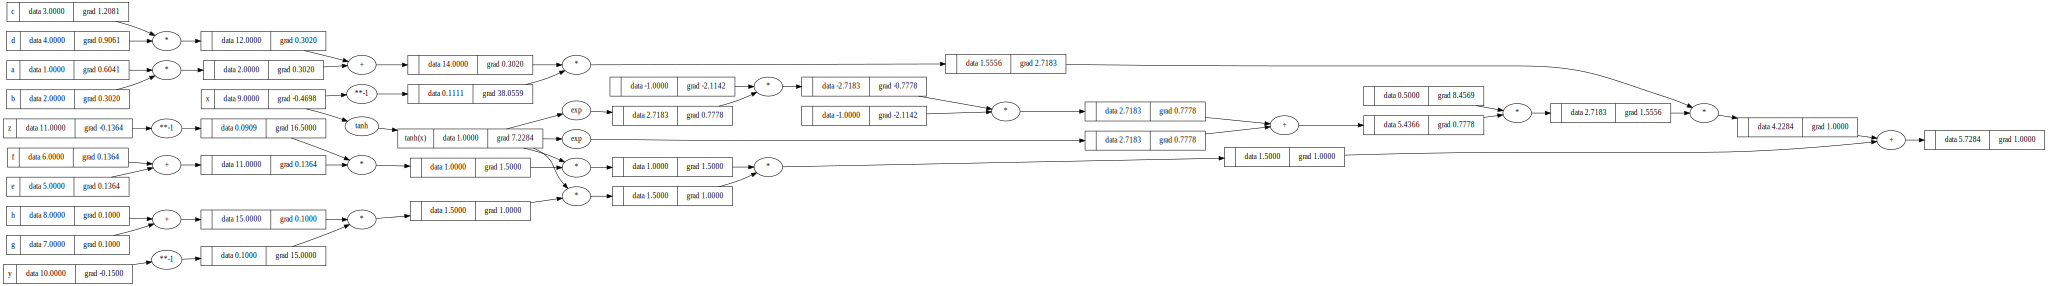

In [5]:
draw_dot(L)

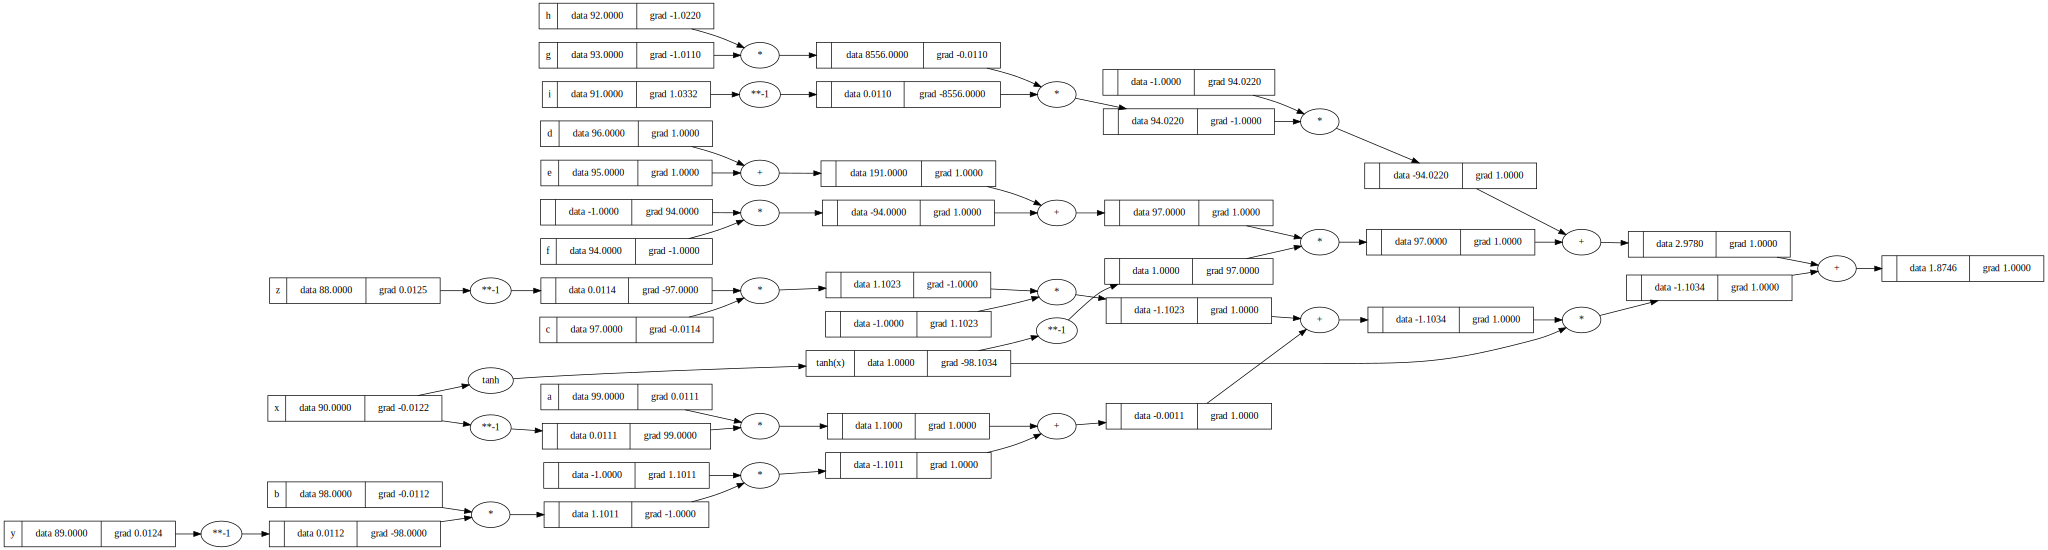

In [6]:
a = Value(99.0); a.label='a'
b = Value(98.0); b.label='b'
c = Value(97.0); c.label='c'
d = Value(96.0); d.label='d'
e = Value(95.0); e.label='e'
f = Value(94.0); f.label='f'
g = Value(93.0); g.label='g'
h = Value(92.0); h.label='h'
i = Value(91.0); i.label='i'
x = Value(90.0); x.label='x'
y = Value(89.0); y.label='y'
z = Value(88.0); z.label='z'
t = x.tanh(); t.label='tanh(x)'

ax = a * (x**-1)
by = b * (y**-1)
cz = c * (z**-1)
ab = ax - by
ac = ab - cz
atan = t*ac
de = d+e
df = de - f
dtan = df * (t**-1)
gh = g*h
gi = gh * (i**-1)
dtani = dtan - gi
L = atan + dtani

L.backward()

draw_dot(L)

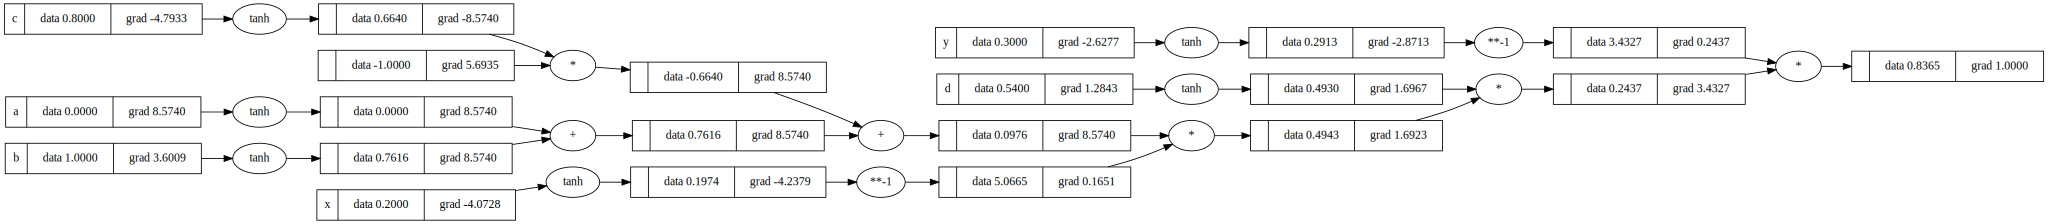

In [7]:
a = Value(0.0); a.label='a'
b = Value(1.0); b.label='b'
c = Value(0.8); c.label='c'
d = Value(0.54); d.label='d'
x = Value(0.2); x.label='x'
y = Value(0.3); y.label='y'
tx = x.tanh(); t.label='tanh(x)'
ty = y.tanh(); t.label='tanh(y)'
ta = a.tanh(); t.label='tanh(a)'
tb = b.tanh(); t.label='tanh(b)'
tc = c.tanh(); t.label='tanh(c)'
td = d.tanh(); t.label='tanh(d)'

ab = ta+tb
ac = ab-tc
ax = ac * (tx**-1)
ad = ax * td
L = ad * (ty**-1)

L.backward()



draw_dot(L)